# Explore Quantum Index Report Full Dataset

In [7]:
#imports

import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from matplotlib.font_manager import FontProperties

#import quantile regression 
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
import re


In [8]:

# read in QPU metris from QPUmetric.csv
# read in QPU metrics from QPUmetric.csv



# read in QPU metrics from QPUmetric.csv
csvfile = 'Datasets/QPUmetrics.csv'
# qpu_metrics = pd.read_csv(csvfile)
#forget the first row
qpu_metrics = pd.read_csv(csvfile, skiprows=1)


#view dataframe
# qpu_metrics


#only select superconducting qpus ie where modality is superconducting
# print(qpu_metrics.columns)
superconducting_qpus = qpu_metrics[qpu_metrics['Modality'] == 'Superconducting']
# print(superconducting_qpus)
#filter out any qpus with dates either not available or past 2024
superconducting_qpus = superconducting_qpus[superconducting_qpus['w'].notna()]
# print(superconducting_qpus)
superconducting_qpus.dropna(subset=['Qubits/ Qumodes', 'w'], inplace=True)
#removing any QPUs where is comercially available is Future plan
superconducting_qpus = superconducting_qpus[superconducting_qpus['Commercially available?'] != 'Future Plan']
# Remove commas from 'Qubits/ Qumodes' and convert to integer
superconducting_qpus['Qubits/ Qumodes'] = superconducting_qpus['Qubits/ Qumodes'].str.replace(',', '').astype(int)
#make the w column an integer
superconducting_qpus['w'] = superconducting_qpus['w'].astype(int)
superconducting_qpus = superconducting_qpus[superconducting_qpus['w'] <= 2024]
# print(superconducting_qpus['Qubits/ Qumodes'])




[(2016, 21.999999999999996), (2018, 72.00000000000001), (2021, 126.99999999999999), (2022, 433.0000000000001), (2023, 1120.9999999999998)]


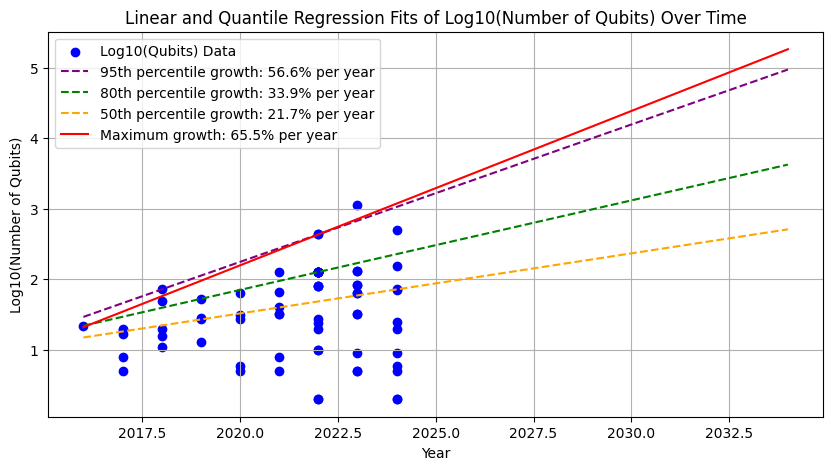

Number of qubits for each model at the year 2025
95th percentile: 1662.8523329045222
80th percentile: 305.1361190304407
50th percentile: 87.60429257878171
Maximum growth: 1959.8849160660657

Projected number of qubits in 2030:
95th percentile projection: 15660
80th percentile projection: 1315
50th percentile projection: 234
Maximum growth projection: 24352


In [12]:

#+====================================================================

#dealing wit max fit
superconducting_qpus = superconducting_qpus.sort_values(by='w')

# Select only the maximum qubit points
max_qubits = -1
max_points = []

for _, row in superconducting_qpus.iterrows():
    if row['Qubits/ Qumodes'] > max_qubits:
        max_qubits = row['Qubits/ Qumodes']
        max_points.append(row)

max_points = pd.DataFrame(max_points)

# Define a linear model for fitting (since y = log10(qubits))
def linear_model(x, a, b):
    return a * x + b

# Extract x (year) and y (log10 of qubits) data for fitting
x_data = max_points['w']  # Year
y_data = np.log10(max_points['Qubits/ Qumodes'])  # Log10 of number of qubits

#print the tuple of this data
print(list(zip(x_data, 10**y_data)))


# Perform linear fitting
params, covariance = curve_fit(linear_model, x_data, y_data)

# Generate fit line
x_fit = np.linspace(x_data.min(), 2034, 100)

y_fit = linear_model(x_fit, *params)


# print(superconducting_qpus)

# #now I want to plot the number of qubits against the year for entries that have number ofqubits available


#make a fit of just the data points where the number of qubits is greater than the number of qubits that have come before
#do a quantile fit on the top 20% of qubits

# Perform quantile regression on the top 20th percentile and median of qubits
y_data = np.log10(superconducting_qpus['Qubits/ Qumodes'])
x_data = superconducting_qpus['w']
model = QuantReg(y_data, sm.add_constant(x_data))

# Fit 95th percentile
res_95 = model.fit(q=0.95)
slope_q95 = res_95.params["w"]
intercept_q95 = res_95.params["const"]

# Fit 80th percentile
res_80 = model.fit(q=0.8)
slope_q80 = res_80.params["w"]
intercept_q80 = res_80.params["const"]

# Fit 50th percentile (median)
res_50 = model.fit(q=0.5)
slope_q50 = res_50.params["w"]
intercept_q50 = res_50.params["const"]

x_fit = np.linspace(x_data.min(), 2034, 100)
# Generate fit lines for quantile regressions
def linear_model(x, a, b):
    return a * x + b
y_quantile_fit_95 = linear_model(x_fit, slope_q95, intercept_q95)
y_quantile_fit_80 = linear_model(x_fit, slope_q80, intercept_q80)
y_quantile_fit_50 = linear_model(x_fit, slope_q50, intercept_q50)

# Calculate yearly growth rates
growth_rate_95 = (10**(slope_q95) - 1) * 100
growth_rate_80 = (10**(slope_q80) - 1) * 100
growth_rate_50 = (10**(slope_q50) - 1) * 100
growth_rate_max = (10**(params[0]) - 1) * 100

# Plot the data points, linear fit, and quantile regression fits
plt.figure(figsize=(10, 5))
plt.scatter(superconducting_qpus['w'], np.log10(superconducting_qpus['Qubits/ Qumodes']), label='Log10(Qubits) Data', color='blue')
plt.plot(x_fit, y_quantile_fit_95, color='purple', linestyle='--', label=f'95th percentile growth: {growth_rate_95:.1f}% per year')
plt.plot(x_fit, y_quantile_fit_80, color='green', linestyle='--', label=f'80th percentile growth: {growth_rate_80:.1f}% per year')
plt.plot(x_fit, y_quantile_fit_50, color='orange', linestyle='--', label=f'50th percentile growth: {growth_rate_50:.1f}% per year')
plt.plot(x_fit, y_fit, color='red', label=f'Maximum growth: {growth_rate_max:.1f}% per year')
plt.xlabel('Year')
plt.ylabel('Log10(Number of Qubits)')
plt.title('Linear and Quantile Regression Fits of Log10(Number of Qubits) Over Time')
plt.legend()
plt.grid()
plt.savefig("Figures/overall_qubit_trend.png")
plt.show()

#print me the number of qubits for each model at the year 2025  
print("Number of qubits for each model at the year 2025")
print(f"95th percentile: {10**(slope_q95*2025 + intercept_q95)}")
print(f"80th percentile: {10**(slope_q80*2025 + intercept_q80)}")
print(f"50th percentile: {10**(slope_q50*2025 + intercept_q50)}")
print(f"Maximum growth: {10**(params[0]*2025 + params[1])}")

# Print projected values for 2030
print("\nProjected number of qubits in 2030:")
print(f"95th percentile projection: {10**(slope_q95*2030 + intercept_q95):.0f}")
print(f"80th percentile projection: {10**(slope_q80*2030 + intercept_q80):.0f}")
print(f"50th percentile projection: {10**(slope_q50*2030 + intercept_q50):.0f}")
print(f"Maximum growth projection: {10**(params[0]*2030 + params[1]):.0f}")
# ==========================================================
# Define roadmap data points




# roadmaps = {
#     'IBM': {
#         'data': [(2020, 27), (2022, 127), (2024, 133), (2025,156), (2029, 22974), (2033, 100000)],
#         'color': 'blue',
#         'marker': 's'
#     },
#     'Google': {
#         'data': [(2019, 54), (2023, 100), (2025, 1000)],
#         'color': 'red', 
#         'marker': '^'
#     }
# }
# # Create figure
# plt.figure(figsize=(12, 8))

# # Plot actual data points
# plt.scatter(superconducting_qpus['w'], np.log10(superconducting_qpus['Qubits/ Qumodes']), 
#            label='Historical Data', color='gray', alpha=0.5)

# # Plot roadmap points and fit lines for each company
# for company, roadmap_info in roadmaps.items():
#     years, qubits = zip(*roadmap_info['data'])
    
#     # Plot scatter points
#     plt.scatter(years, np.log10(qubits),
#                label=f'{company} Roadmap',
#                color=roadmap_info['color'],
#                marker=roadmap_info['marker'],
#                s=100)
    
#     # Fit line to roadmap points
#     z = np.polyfit(years, np.log10(qubits), 1)
#     p = np.poly1d(z)
    
#     # Calculate growth rate
#     company_growth_rate = (10**z[0] - 1) * 100
    
#     # Generate points for the fit line
#     x_company_fit = np.linspace(min(years), max(years), 100)
#     y_company_fit = p(x_company_fit)
    
#     # Plot fit line
#     plt.plot(x_company_fit, y_company_fit, 
#              color=roadmap_info['color'],
#              linestyle=':',
#              label=f'{company} Fit: {company_growth_rate:.1f}% per year')

# # Plot the quantile regression lines
# plt.plot(x_fit, y_quantile_fit_95, color='purple', linestyle='--',
#          label=f'95th percentile growth: {growth_rate_95:.1f}% per year')
# plt.plot(x_fit, y_quantile_fit_80, color='darkgreen', linestyle='--',
#          label=f'80th percentile growth: {growth_rate_80:.1f}% per year')
# plt.plot(x_fit, y_quantile_fit_50, color='orange', linestyle='--',
#          label=f'50th percentile growth: {growth_rate_50:.1f}% per year')
# plt.plot(x_fit, y_fit, color='red',
#          label=f'Maximum growth: {growth_rate_max:.1f}% per year')

# plt.xlabel('Year')
# plt.ylabel('Log10(Number of Qubits)')
# plt.title('Quantum Computer Roadmaps vs Historical Trends')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(True)
# plt.tight_layout()

# plt.show()

# Plot the data points and the fit
# plt.figure(figsize=(10, 5))
# plt.scatter(max_points['w'], np.log10(max_points['Qubits/ Qumodes']), label='Log10(Qubits) Data', color='blue')
# plt.plot(x_fit, y_fit, color='red', label=f'Fit: log10(Qubits) = {params[0]:.2f}*Year + {params[1]:.2f}')
# plt.xlabel('Year')
# plt.ylabel('Log10(Number of Qubits)') 
# plt.title('Linear Fit of Log10(Number of Qubits) Over Time')
# plt.legend()
# plt.grid()
# plt.show()



# Neutral Atom Observations

                                               Sources  \
12   Quantum Insider; https://atom-computing.com/qu...   
13   Quantum Insider, Atom announcement https://moo...   
110  Quantum Insider, https://quantumtech.blog/2022...   
111  Quantum Insider, https://www.infleqtion.com/co...   
144  https://learn.microsoft.com/en-us/azure/quantu...   
192                 Ezratty, https://www.quera.com/qec   

    Confirmed by manufacturer?                                Comments  \
12                         NaN                                     NaN   
13                         NaN                                     NaN   
110                        Yes  CZ fidelity only tested on first qubit   
111                        Yes                                     NaN   
144                        NaN                                     NaN   
192                        NaN                                     NaN   

                               Name sent  \
12                Justin Ging 

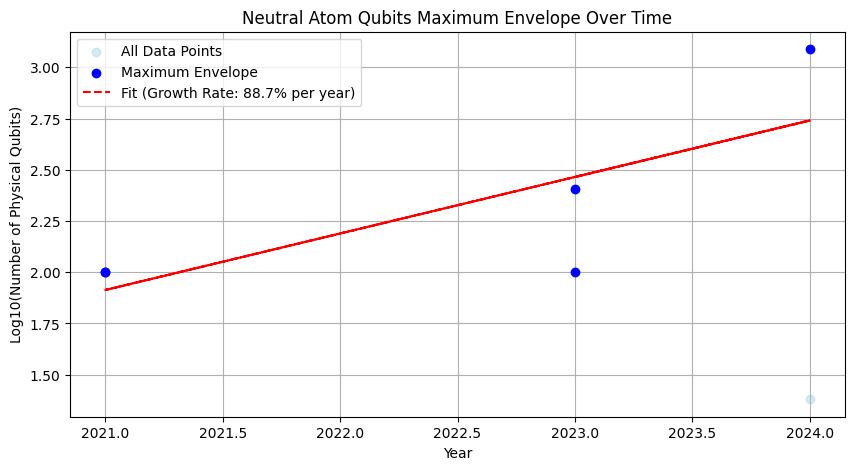

In [10]:
#Graph of neutral atom trends 
neutral_atom_qubits = qpu_metrics[qpu_metrics['Modality'] == 'Neutral Atoms']
#only select onesw with commercially available 
neutral_atom_qubits = neutral_atom_qubits[neutral_atom_qubits['w'].notna()]
neutral_atom_qubits.dropna(subset=['Qubits/ Qumodes', 'w'], inplace=True)
neutral_atom_qubits = neutral_atom_qubits[neutral_atom_qubits['Commercially available?'] != 'Future Plan']
neutral_atom_qubits['Qubits/ Qumodes'] = neutral_atom_qubits['Qubits/ Qumodes'].str.replace(',', '').astype(int)
neutral_atom_qubits['w'] = neutral_atom_qubits['w'].astype(int)
neutral_atom_qubits = neutral_atom_qubits[neutral_atom_qubits['w'] <= 2024]

print(neutral_atom_qubits)


#make a fit of log neutral atom qubits against the year 
neutral_atom_qubits_fit = np.polyfit(neutral_atom_qubits['w'], np.log10(neutral_atom_qubits['Qubits/ Qumodes']), 1)
neutral_atom_qubits_fit = np.poly1d(neutral_atom_qubits_fit)


#make a plot of the neutral atom qubits against the year 
# plt.figure(figsize=(10, 5))
# plt.scatter(neutral_atom_qubits['w'], np.log10(neutral_atom_qubits['Qubits/ Qumodes']), label='Neutral Atom Qubits', color='blue')
# plt.plot(neutral_atom_qubits['w'], neutral_atom_qubits_fit(neutral_atom_qubits['w']), label='Neutral Atom Qubits Fit', color='red')
# plt.xlabel('Year')
# plt.ylabel('Log10(Number of Physical Qubits)')
# plt.title('Neutral Atom Qubits Over Time')


#make a max qubit fit for neutral atoms ie take the point that are higher than any previous point and fit a line to it 

# Create a function to get the cumulative maximum points
def get_max_envelope(df):
    # Sort by year
    df_sorted = df.sort_values('w')
    # Get cumulative maximum
    max_mask = df_sorted['Qubits/ Qumodes'].cummax() == df_sorted['Qubits/ Qumodes']
    return df_sorted[max_mask]

# Get the maximum envelope points
max_envelope = get_max_envelope(neutral_atom_qubits)

# Fit to the log of the maximum envelope points
max_fit = np.polyfit(max_envelope['w'], np.log10(max_envelope['Qubits/ Qumodes']), 1)
max_fit = np.poly1d(max_fit)

# Calculate growth rate
growth_rate = (10**max_fit[1] - 1) * 100

# Create the plot
plt.figure(figsize=(10, 5))
# Plot all points in lighter color
plt.scatter(neutral_atom_qubits['w'], np.log10(neutral_atom_qubits['Qubits/ Qumodes']), 
           label='All Data Points', color='lightblue', alpha=0.5)
# Plot maximum envelope points
plt.scatter(max_envelope['w'], np.log10(max_envelope['Qubits/ Qumodes']), 
           label='Maximum Envelope', color='blue', zorder=5)
# Plot the fit line
plt.plot(neutral_atom_qubits['w'], max_fit(neutral_atom_qubits['w']), 
         label=f'Fit (Growth Rate: {growth_rate:.1f}% per year)', 
         color='red', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Log10(Number of Physical Qubits)')
plt.title('Neutral Atom Qubits Maximum Envelope Over Time')
plt.legend()
plt.grid(True)

# Phontonic Quantum Computers Trends

                                               Sources  \
149  Quantum Insider, https://www.php.cn/faq/179655...   
150  Quantum Insider, https://www.php.cn/faq/179655...   
153   https://quantumcomputinginc.com/products/dirac-2   
154  https://www.hpcwire.com/off-the-wire/qci-launc...   
157  https://thequantuminsider.com/2024/05/07/quand...   
158  https://thequantuminsider.com/2024/05/07/quand...   
159  Ezratty, https://www.quandela.com/wp-content/u...   
193  https://www.quixquantum.com/products/special-p...   
194                   https://arxiv.org/pdf/2203.01801   
197  https://asiatimes.com/2023/10/china-unveils-fa...   
198  https://asiatimes.com/2023/10/china-unveils-fa...   
234  https://www.xanadu.ai/blog/beating-classical-c...   
235  https://spie.org/news/photonics-focus/novdec-2...   
236  https://spie.org/news/photonics-focus/novdec-2...   
237  https://spie.org/news/photonics-focus/novdec-2...   

    Confirmed by manufacturer?                     Comments  \
149     

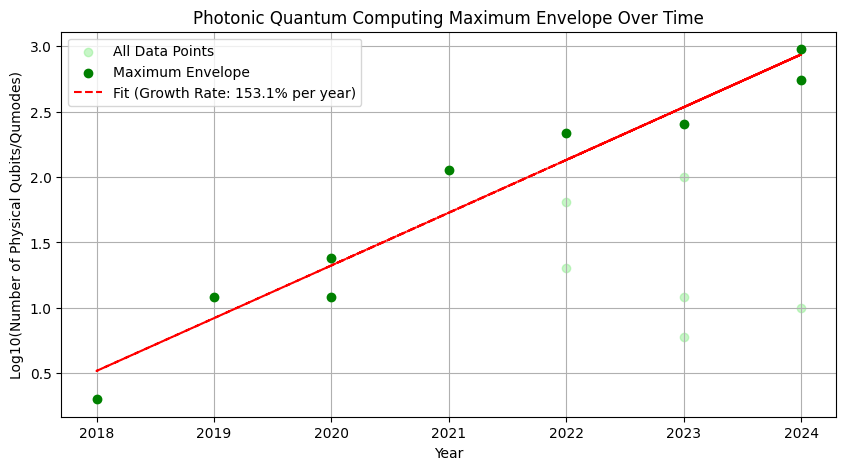

In [11]:
# Graph of photonic quantum computing trends 
photonic_qubits = qpu_metrics[qpu_metrics['Modality'] == 'Photonics']
# Only select ones with dates
photonic_qubits = photonic_qubits[photonic_qubits['w'].notna()]
photonic_qubits.dropna(subset=['Qubits/ Qumodes', 'w'], inplace=True)
photonic_qubits = photonic_qubits[photonic_qubits['Commercially available?'] != 'Future Plan']

# Clean the Qubits/Qumodes column
def clean_number(x):
    try:
        # Convert to string and remove any commas
        x = str(x).replace(',', '')
        # Remove any whitespace
        x = x.strip()
        # Check for obvious non-numeric entries
        if x in ['?', 'N/A', '', 'nan', 'None']:
            return None
        # Extract just the numbers using regex
        import re
        numbers = re.findall(r'\d+', x)
        if numbers:
            return int(numbers[0])
        return None
    except:
        return None

# Clean and convert both columns
photonic_qubits['Qubits/ Qumodes'] = photonic_qubits['Qubits/ Qumodes'].apply(clean_number)
photonic_qubits['w'] = photonic_qubits['w'].apply(clean_number)

# Drop any rows where the conversion failed (resulted in None)
photonic_qubits = photonic_qubits.dropna(subset=['Qubits/ Qumodes', 'w'])
photonic_qubits = photonic_qubits[photonic_qubits['w'] <= 2024]

print(photonic_qubits)

# Get the maximum envelope points
max_envelope = get_max_envelope(photonic_qubits)


#setup quantile regression 
y_data = np.log10(superconducting_qpus['Qubits/ Qumodes'])
x_data = superconducting_qpus['w']
# model = QuantReg(y_data, sm.add_constant(x_data))




# Fit to the log of the maximum envelope points
max_fit = np.polyfit(max_envelope['w'], np.log10(max_envelope['Qubits/ Qumodes']), 1)
max_fit = np.poly1d(max_fit)

# Calculate growth rate
growth_rate = (10**max_fit[1] - 1) * 100

# Create the plot
plt.figure(figsize=(10, 5))
# Plot all points in lighter color
plt.scatter(photonic_qubits['w'], np.log10(photonic_qubits['Qubits/ Qumodes']), 
           label='All Data Points', color='lightgreen', alpha=0.5)
# Plot maximum envelope points
plt.scatter(max_envelope['w'], np.log10(max_envelope['Qubits/ Qumodes']), 
           label='Maximum Envelope', color='green', zorder=5)
# Plot the fit line
plt.plot(photonic_qubits['w'], max_fit(photonic_qubits['w']), 
         label=f'Fit (Growth Rate: {growth_rate:.1f}% per year)', 
         color='red', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Log10(Number of Physical Qubits/Qumodes)')
plt.title('Photonic Quantum Computing Maximum Envelope Over Time')
plt.legend()
plt.grid(True)

# Just Roadmaps Analysis

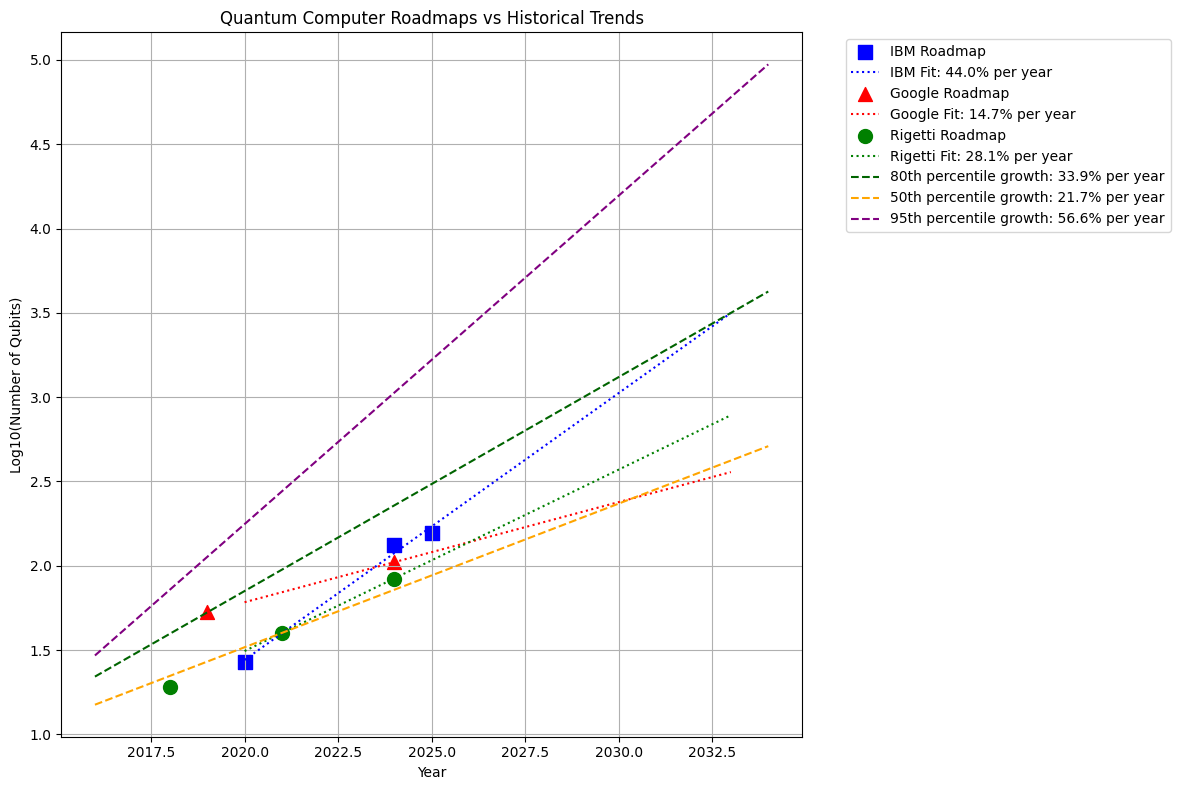


Projected number of qubits in 2030:
80th percentile projection: 1315
50th percentile projection: 234


In [14]:
# Define roadmap data points
roadmaps = {
    'IBM': {
        'data': [(2020, 27), (2024, 133), (2025,156)],
        'color': 'blue',
        'marker': 's'
    },
    'Google': {
        'data': [(2019, 53), (2024, 105)],
        'color': 'red', 
        'marker': '^'
    },
    'Rigetti': {
        'data': [(2018, 19), (2021, 40), (2024, 84)],
        'color': 'green',
        'marker': 'o'
    }
}
# Create figure
plt.figure(figsize=(12, 8))

# Plot roadmap points and fit lines for each company
for company, roadmap_info in roadmaps.items():
    years, qubits = zip(*roadmap_info['data'])
    
    # Plot scatter points
    plt.scatter(years, np.log10(qubits),
               label=f'{company} Roadmap',
               color=roadmap_info['color'],
               marker=roadmap_info['marker'],
               s=100)
    
    # Fit line to roadmap points
    z = np.polyfit(years, np.log10(qubits), 1)
    p = np.poly1d(z)
    
    # Calculate growth rate
    company_growth_rate = (10**z[0] - 1) * 100
    
    # Generate points for the fit line
    x_company_fit = np.linspace(2020, 2033, 100)
    y_company_fit = p(x_company_fit)
    
    # Plot fit line
    plt.plot(x_company_fit, y_company_fit, 
             color=roadmap_info['color'],
             linestyle=':',
             label=f'{company} Fit: {company_growth_rate:.1f}% per year')

# Plot the quantile regression lines
plt.plot(x_fit, y_quantile_fit_80, color='darkgreen', linestyle='--',
         label=f'80th percentile growth: {growth_rate_80:.1f}% per year')
plt.plot(x_fit, y_quantile_fit_50, color='orange', linestyle='--',
         label=f'50th percentile growth: {growth_rate_50:.1f}% per year')
#95 quartile regression line 
plt.plot(x_fit, y_quantile_fit_95, color='purple', linestyle='--',
         label=f'95th percentile growth: {growth_rate_95:.1f}% per year')

plt.xlabel('Year')
plt.ylabel('Log10(Number of Qubits)')
plt.title('Quantum Computer Roadmaps vs Historical Trends')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig("Figures/roadmap_comparison.png")
plt.show()

# Print projected values for 2030
print("\nProjected number of qubits in 2030:")
print(f"80th percentile projection: {10**(slope_q80*2030 + intercept_q80):.0f}")
print(f"50th percentile projection: {10**(slope_q50*2030 + intercept_q50):.0f}")


# Roadmap Graph For Presentation

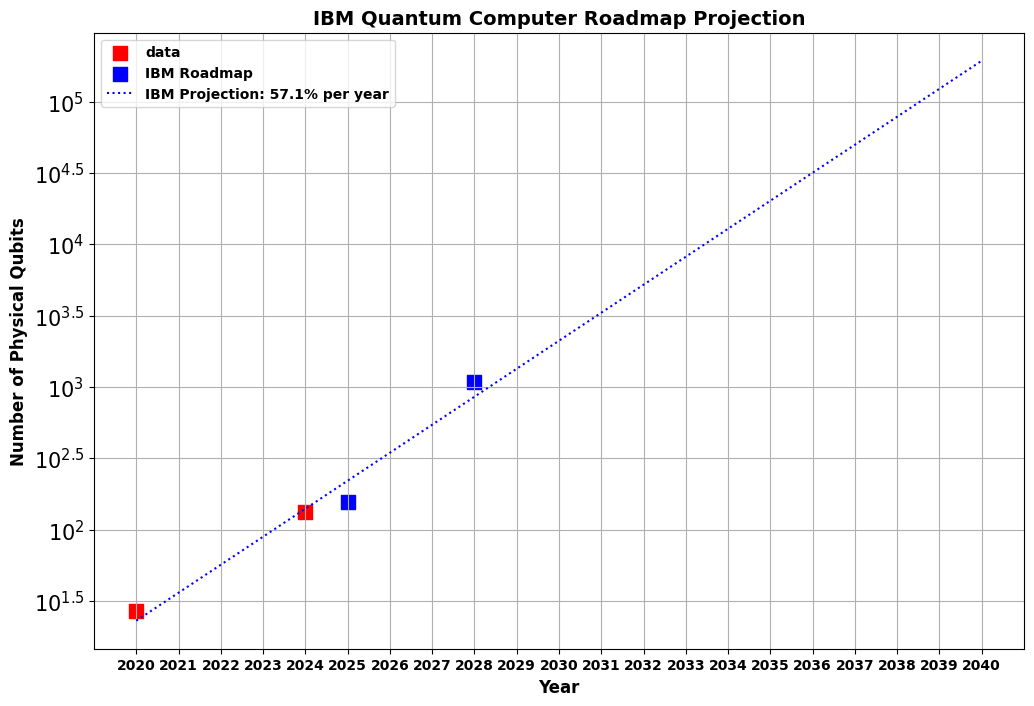

In [20]:
roadmaps = {
    'IBM': {
        'data': [(2020, 27), (2024, 133), (2025, 156), (2028, 1092)],
        'color': 'blue',
        'marker': 's'
    },
    'Google': {
        'data': [(2019, 54), (2023, 100), (2025, 1000)],
        'color': 'red', 
        'marker': '^'
    },
    'Rigetti': {
        'data': [(2023, 336), (2025, 1000), (2027, 4000)],
        'color': 'green',
        'marker': 'o'
    }
}


# Create figure
plt.figure(figsize=(12, 8))

# Plot actual IBM roadmap points
years, qubits = zip(*roadmaps['IBM']['data'])

# Separate data points before 2025 and after/equal to 2025
pre_2025_years = [y for y in years if y < 2025]
pre_2025_qubits = [qubits[i] for i, y in enumerate(years) if y < 2025]
post_2025_years = [y for y in years if y >= 2025]
post_2025_qubits = [qubits[i] for i, y in enumerate(years) if y >= 2025]

# Plot scatter points for IBM - pre 2025 in red
plt.scatter(pre_2025_years, np.log10(pre_2025_qubits),
           label='data',
           color='red',
           marker=roadmaps['IBM']['marker'],
           s=100)

# Plot scatter points for IBM - post 2025 in blue
if post_2025_years:
    plt.scatter(post_2025_years, np.log10(post_2025_qubits),
               label='IBM Roadmap',
               color=roadmaps['IBM']['color'],
               marker=roadmaps['IBM']['marker'],
               s=100)

# Fit line to roadmap points
z = np.polyfit(years, np.log10(qubits), 1)
p = np.poly1d(z)

# Calculate growth rate
ibm_growth_rate = (10**z[0] - 1) * 100

# Generate points for the fit line
x_company_fit = np.linspace(min(years), 2040, 100)
y_company_fit = p(x_company_fit)

# Plot fit line
plt.plot(x_company_fit, y_company_fit, 
         color=roadmaps['IBM']['color'],
         linestyle=':',
         label=f'IBM Projection: {ibm_growth_rate:.1f}% per year')

# Add labels and title with darker and bolder styling
plt.xlabel('Year', fontweight='bold', color='black', fontsize=12)
plt.ylabel('Number of Physical Qubits', fontweight='bold', color='black', fontsize=12)
plt.title('IBM Quantum Computer Roadmap Projection', fontweight='bold', fontsize=14)
plt.legend(prop={'weight':'bold', 'size':10})
plt.grid(True)

# Make tick labels darker and bolder
plt.xticks(range(2020, 2041, 1), fontweight='bold', color='black')
plt.yticks(fontweight='bold', color='black', fontsize=15)

# Set y-axis to use scientific notation (10^x format)
from matplotlib.ticker import ScalarFormatter, LogFormatter, FuncFormatter

def log_tick_formatter(val, pos=None):
    return f'$10^{{{int(val)}}}$' if val == int(val) else f'$10^{{{val:.1f}}}$'

plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

plt.show()

# Gate Times Over Time

Slope: 0.8740312402675646
Intercept: 120.46139732348037
                         QuantReg Regression Results                          
Dep. Variable:        log10_gate_time   Pseudo R-squared:              0.06955
Model:                       QuantReg   Bandwidth:                         nan
Method:                 Least Squares   Sparsity:                          nan
Date:                Thu, 03 Apr 2025   No. Observations:                   23
Time:                        21:32:22   Df Residuals:                       21
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    135.1408        nan        nan        nan         nan         nan
year          -0.0659        nan        nan        nan         nan         nan

The condition number is large, 2.24e+06. This might indicate that there ar

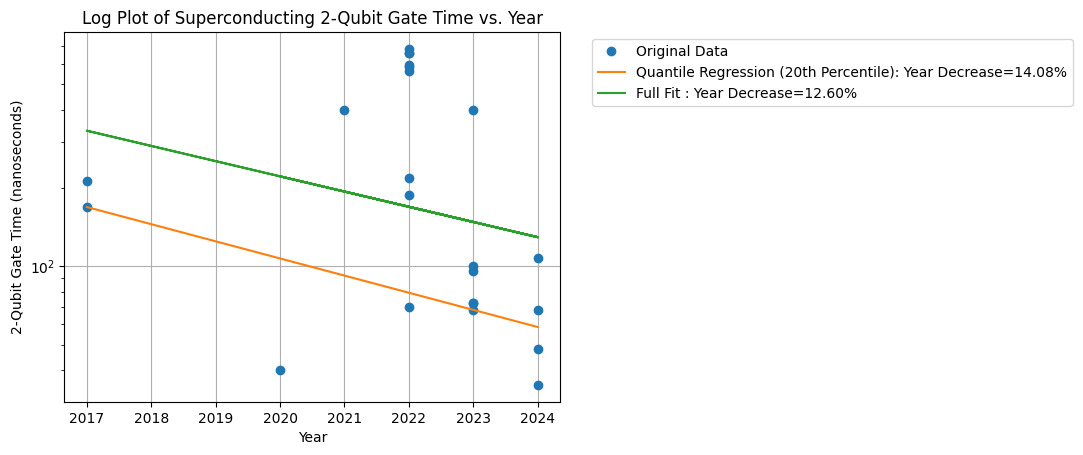

In [8]:
# original code
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf

year_gate_time = [
    (2024, 35),
    (2022, 594),
    (2022, 660),
    (2022, 586),
    (2022, 660),
    (2022, 685),
    (2023, 68),
    (2022, 561),
    (2024, 68),
    (2024, 48),
    (2023, 100),
    (2021, 400),
    (2023, 400),
    (2020, 40),
    (2023, 72),
    (2023, 96),
    (2023, 72),
    (2024, 108),
    (2022, 218),
    (2022, 188),
    (2017, 169),
    (2017, 213),
    (2022, 70),
]

# Extract years and gate times
years = np.array([x[0] for x in year_gate_time])
gate_times = np.array([x[1] for x in year_gate_time])

# Log-transform the gate times using base 10
log10_gate_times = np.log10(gate_times)

# Perform linear regression on the log-transformed gate times
coefficients = np.polyfit(years, log10_gate_times, 1)
linear_fit = np.poly1d(coefficients)

# Print the fit parameters
slope, intercept = coefficients
print(f"Slope: {10**slope}")
print(f"Intercept: {intercept}")
# Create DataFrame
df = pd.DataFrame(year_gate_time, columns=["year", "gate_time"])

# Log-transform the gate times using base 10
df['log10_gate_time'] = np.log10(df['gate_time'])

# Perform quantile regression for the 20th percentile on the log-transformed gate times
quantile = 0.2
model = smf.quantreg('log10_gate_time ~ year', df)
res = model.fit(q=quantile)

# Print the quantile regression results
print(res.summary())

# Generate fitted values for a smooth line
years_smooth = np.linspace(min(df['year']), max(df['year']), 100)
fitted_quantile_log10_gate_times = res.predict(pd.DataFrame({'year': years_smooth}))
fitted_quantile_gate_times = 10**fitted_quantile_log10_gate_times

print(res.params)

# Plot the original data
plt.plot(df['year'], df['gate_time'], "o", label="Original Data")

# Plot the continuous fit line for the quantile regression
plt.plot(
    years_smooth,
    fitted_quantile_gate_times,
    "-",
    label=f"Quantile Regression (20th Percentile): Year Decrease={(1-10**res.params['year']):.2%}",
)

# Generate fitted values for the linear regression
fitted_log10_gate_times = linear_fit(years)
fitted_gate_times = 10**fitted_log10_gate_times

# Plot the linear regression fit line
plt.plot(
    years,
    fitted_gate_times,
    "-",
    label=f"Full Fit : Year Decrease={(1-10**slope):.2%}",
)

plt.yscale("log")
plt.xlabel("Year")
plt.ylabel("2-Qubit Gate Time (nanoseconds)")
plt.title("Log Plot of Superconducting 2-Qubit Gate Time vs. Year")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf



# ==========================================================
# 1. Input Data
# ==========================================================
year_gate_time = [
    (2024, 35),
    (2022, 594),
    (2022, 660),
    (2022, 586),
    (2022, 660),
    (2022, 685),
    (2023, 68),
    (2022, 561),
    (2024, 68),
    (2024, 48),
    (2023, 100),
    (2021, 400),
    (2023, 400),
    (2020, 40),
    (2023, 72),
    (2023, 96),
    (2023, 72),
    (2024, 108),
    (2022, 218),
    (2022, 188),
    (2017, 169),
    (2017, 213),
    (2022, 70),
]

# ==========================================================
# 2. Prepare Arrays
# ==========================================================
years = np.array([x[0] for x in year_gate_time])
gate_times = np.array([x[1] for x in year_gate_time])

# Log-transform the gate times (base 10)
log10_gate_times = np.log10(gate_times)

# ==========================================================
# 3. Linear Regression in log-space WITH Covariance
#    to get standard errors
# ==========================================================
coeffs, cov = np.polyfit(years, log10_gate_times, 1, cov=True)
slope, intercept = coeffs
slope_err = np.sqrt(cov[0, 0])
intercept_err = np.sqrt(cov[1, 1])

# Convert slope to "yearly factor"
#   log10(gate_time) = slope*year + intercept
# => gate_time = 10^(slope*year + intercept) = 10^intercept * 10^(slope*year)
#
# The fraction by which gate_time changes per year is 10^slope.
# => yearly percent DECREASE = (1 - 10^slope)*100

yearly_factor = 10**slope  # multiply factor each year
# Propagate uncertainty:
#   derivative wrt slope = d(10^slope)/d(slope) = ln(10)*10^slope
yearly_factor_err = np.log(10) * 10**slope * slope_err

percent_decrease = (1 - yearly_factor) * 100
percent_decrease_err = yearly_factor_err * 100

print("=== Linear Regression in Log-Space ===")
print(f"Fitted slope (log10 space): {slope:.4f} ± {slope_err:.4f}")
print(f"Fitted intercept (log10 space): {intercept:.4f} ± {intercept_err:.4f}")
print(f"Yearly factor = 10^slope = {yearly_factor:.3f} ± {yearly_factor_err:.3f}")
print(f"Yearly percent decrease = (1 - {yearly_factor:.3f}) * 100 = "
      f"{percent_decrease:.2f}% ± {percent_decrease_err:.2f}%")

# Build a polynomial model for plotting (linear fit in log-space)
linear_fit = np.poly1d(coeffs)

# ==========================================================
# 4. Quantile Regression (20th Percentile)
#    and standard error of the slope
# ==========================================================
df = pd.DataFrame(year_gate_time, columns=["year", "gate_time"])
df["log10_gate_time"] = np.log10(df["gate_time"])

quantile = 0.2
model = smf.quantreg("log10_gate_time ~ year", df)
res = model.fit(q=quantile)

slope_q = res.params["year"]
intercept_q = res.params["Intercept"]
slope_q_err = res.bse["year"]
intercept_q_err = res.bse["Intercept"]

# Convert slope to "yearly factor" and find percent decrease
yearly_factor_q = 10**slope_q
yearly_factor_q_err = np.log(10) * 10**slope_q * slope_q_err

percent_decrease_q = (1 - yearly_factor_q) * 100
percent_decrease_q_err = yearly_factor_q_err * 100

print("\n=== 20th Percentile Quantile Regression ===")
print(res.summary())
print(f"Quantile slope (log10 space): {slope_q:.4f} ± {slope_q_err:.4f}")
print(f"Quantile intercept (log10 space): {intercept_q:.4f} ± {intercept_q_err:.4f}")
print(f"Yearly factor = 10^slope_q = {yearly_factor_q:.3f} ± {yearly_factor_q_err:.3f}")
print(f"Yearly percent decrease (quantile) = (1 - {yearly_factor_q:.3f}) * 100 = "
      f"{percent_decrease_q:.2f}% ± {percent_decrease_q_err:.2f}%")





=== Linear Regression in Log-Space ===
Fitted slope (log10 space): -0.0585 ± 0.0498
Fitted intercept (log10 space): 120.4614 ± 100.7729
Yearly factor = 10^slope = 0.874 ± 0.100
Yearly percent decrease = (1 - 0.874) * 100 = 12.60% ± 10.03%

=== 20th Percentile Quantile Regression ===
                         QuantReg Regression Results                          
Dep. Variable:        log10_gate_time   Pseudo R-squared:              0.06955
Model:                       QuantReg   Bandwidth:                         nan
Method:                 Least Squares   Sparsity:                          nan
Date:                Thu, 03 Apr 2025   No. Observations:                   23
Time:                        21:32:24   Df Residuals:                       21
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

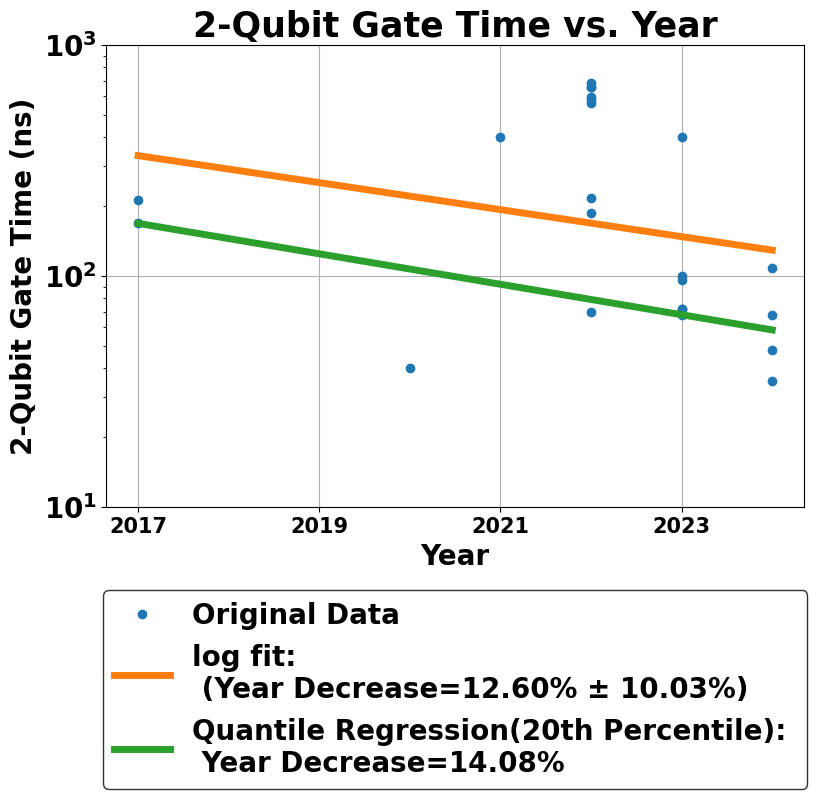

In [10]:

# ==========================================================
# 5. Plot Results
# ==========================================================
# plt.figure(figsize=(10,10))
# plt.figure(figsize=(15, 8))
plt.figure(figsize=(9, 6))

# Original data
plt.plot(df["year"], df["gate_time"], "o", label="Original Data")

# Continuous x-range for smooth lines
years_smooth = np.linspace(min(df["year"]), max(df["year"]), 100)

# -- Linear Regression Fit --
fitted_log10_gate_times = linear_fit(years_smooth)
fitted_gate_times = 10**fitted_log10_gate_times
plt.plot(
    years_smooth,
    fitted_gate_times,
    "-",
    label=(
        "log fit: \n "
        f"(Year Decrease={(1 - 10**slope):.2%} ± {percent_decrease_err:.2f}%)"
    ),
    linewidth=5,
)

# -- Quantile Regression Fit --
fitted_quantile_log10_gate_times = res.predict(pd.DataFrame({"year": years_smooth}))
fitted_quantile_gate_times = 10**fitted_quantile_log10_gate_times


plt.plot(
    years_smooth,
    fitted_quantile_gate_times,
    "-",
    label=(
        f"Quantile Regression(20th Percentile): \n Year Decrease={(1 - 10**slope_q):.2%} "
    ),
    linewidth=5,
)

# Log scale on the y-axis
plt.yscale("log")
plt.xlabel("Year", fontweight='bold', fontsize=20)
plt.ylabel("2-Qubit Gate Time (ns)", fontweight='bold', fontsize=20)

font_properties = FontProperties()
font_properties.set_size(20)
font_properties.set_weight('bold')
#old legend format
# plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=20, frameon=True, shadow=True, facecolor='white', edgecolor='black', fancybox=True, prop=font_properties)

# plt.legend(bbox_to_anchor=(0.5, -0.35), loc="upper center", fontsize=20, frameon=True, shadow=True, facecolor='white', edgecolor='black', fancybox=True, prop=font_properties)

plt.legend(fontsize=20,
          loc='upper center',
          bbox_to_anchor=(0.5, -0.15), 
          frameon=True,  # Adds a frame around the legend
          facecolor='white',  # White background
          edgecolor='black', prop=font_properties)  # Black border

plt.yticks(fontsize=20, fontweight="bold")
plt.ylim(10, 1000)
plt.xticks(np.arange(2017, 2025, 2), fontsize=15, fontweight="bold")
plt.grid(True)
plt.grid(True)
# plt.tight_layout()
plt.title("2-Qubit Gate Time vs. Year", fontsize=25, fontweight='bold')
plt.savefig("Figures/2-qubit-gate-time-vs-year.png", dpi=300, bbox_inches='tight')
plt.show()


# Gate Error Rate

In [12]:
# extracting data for erorr rate in dataframe

import pandas as pd
from io import StringIO

data = """\
N/A	Photonics
2018	Superconducting
2022	Superconducting	99.72%
2024	Superconducting	98.4000%
2024	Superconducting	95.6000%
2022	Trapped Ions	98.70%
2022	Trapped Ions	98.50%
2021	Trapped Ions	98.50%
N/A	Trapped Ions
N/A	Electron Spin
N/A	Electron Spin
N/A	Superconducting
2021	Neutral Atoms
2024	Neutral Atoms
N/A	Neutral Atoms
N/A	Neutral Atoms
N/A	Neutral Atoms
2022	Superconducting	96.6000%
N/A	Electron Spin
N/A	Trapped Ions
N/A	Electron Spin
N/A	Electron Spin	98.9200%
N/A	Electron Spin
N/A	Photonics
2024	Annealer
2007	Annealer
2011	Annealer
2013	Annealer
2015	Annealer
2017	Annealer
2021	Annealer
	Annealer
N/A	Superconducting
2030	Trapped Ions
2025	Electron Spin
2021	Electron Spin
2023	Superconducting
2026	Superconducting
2023	Superconducting
N/A	Neutral Atoms
2017	Superconducting
2018	Superconducting	99.4000%
2019	Superconducting	98.6000%
2025	Superconducting
N/A	Superconducting
N/A	Superconducting
N/A	Superconducting
2024	Superconducting
2016	Superconducting
N/A	Trapped Ions
2022	Electron Spin	96.30%
N/A	Trapped Ions
2022	Superconducting
	Superconducting	98.5800%
2017	Superconducting	95.9800%
2018	Superconducting	97.1600%
2019	Superconducting
2020	Superconducting
	Superconducting	95.0400%
2020	Superconducting
2021	Superconducting
2022	Superconducting
2023	Superconducting
2022	Superconducting
2023	Superconducting
2024	Superconducting
2025	Superconducting
2029	Superconducting
2033	Superconducting
	Superconducting	98.8200%
	Superconducting	95.3600%
	Superconducting	98.9100%
	Superconducting
	Superconducting	97.8700%
	Superconducting
	Superconducting	98.3100%
2025	Superconducting
2027	Superconducting
	Superconducting	97.7500%
	Superconducting	98.2800%
	Superconducting	99.0500%
	Superconducting	99.0300%
	Superconducting	94.8700%
	Superconducting	98.9200%
	Superconducting	91.1800%
2022	Superconducting	99.2382%
2022	Superconducting	99.0096%
2022	Superconducting	99.3041%
2022	Superconducting	99.2283%
2022	Superconducting	99.1828%
2022	Superconducting	99.2383%
	Superconducting	92.8400%
	Superconducting	97.8100%
	Superconducting	99.0300%
	Superconducting
	Superconducting
	Superconducting	98.9600%
	Superconducting	98.9700%
	Superconducting	98.8900%
2022	Superconducting	99.3160%
	Superconducting	98.7400%
	Superconducting	98.9800%
2023	Superconducting	99.6921%
2022	Superconducting	98.8250%
2022	Superconducting	98.9260%
2022	Superconducting	99.1686%
2024	Superconducting	99.7039%
	Superconducting
	Superconducting
	Superconducting
2021	Neutral Atoms	92.0000%
2024	Neutral Atoms	99.3500%
2028	Neutral Atoms	99.9500%
2023	Electron Spin
2017	Superconducting
2018	Superconducting
2019	Trapped Ions	97.3000%
2020	Trapped Ions	99.4000%
2022	Trapped Ions	99.6000%
2024	Trapped Ions	99.6000%
2025	Trapped Ions	99.9000%
2024	Superconducting	99.5100%
2023	Superconducting	99.1400%
2024	Superconducting
2024	Superconducting	97%
2025	Superconducting
2021	Superconducting
N/A	Neutral Atoms
2023	Annealer
N/A	Trapped Ions
2028	Superconducting
2021	Photonics
2020	Superconducting	98.0000%
2022	Superconducting
2024	Superconducting
2024	Superconducting	96.8600%
N/A	Trapped Ions
2024	Trapped Ions	99.9700%
2021	Superconducting	94.0000%
2023	Superconducting	96%
2023	Neutral Atoms	98.5000%
2024-25	Neutral Atoms
2026-27	Neutral Atoms
2028	Neutral Atoms
2023	Neutral Atoms
2029	Electron Spin
N/A	Photonics
N/A	Neutral Atoms
2029	Photonics	99.0000%
2023	Photonics
2024	Photonics
N/A	Photonics
2022	Photonics
2022	Photonics
2024	Photonics
2025	Annealer
N/A	Superconducting
2023	Photonics
2024	Photonics
2023	Photonics	93.8000%
N/A	Photonics
N/A	Neutral Atoms
2023	Trapped Ions	99.8700%
2023	Trapped Ions	99.9140%
2025	Trapped Ions	99.9950%
2027	Trapped Ions	99.9980%
2029	Trapped Ions	99.9990%
2021	Trapped Ions	99.7700%
2020	Trapped Ions	99.5000%
2021	Trapped Ions	99.7000%
2022	Trapped Ions	99.7000%
2023	Trapped Ions	99.8160%
2020	Trapped Ions	99.2000%
N/A	Trapped Ions
2022	Electron Spin	99.20%
2026	Electron Spin
N/A	Electron Spin
2020	Superconducting
2020	Electron Spin
N/A	Superconducting
N/A	Superconducting
N/A	Electron Spin
N/A	Photonics
N/A	Electron Spin
2024	Superconducting
2024	Superconducting
2023	Superconducting
2024	Superconducting	99.7000%
N/A	Trapped Ions
2024	Neutral Atoms
2025	Neutral Atoms
2026	Neutral Atoms
2023	Neutral Atoms	99.4800%
2022	Photonics
2020	Photonics
N/A	Electron Spin
N/A	Electron Spin
2021	Photonics
2023	Photonics
?	Photonics
2021	Superconducting
2023	Superconducting	94.9000%
2023	Superconducting	97.5000%
2023	Superconducting	97.8000%
2024	Superconducting	99.2000%
2018	Superconducting	90.8400%
2019	Superconducting	94.4200%
2019	Superconducting	95.2000%
2020	Superconducting	94.3400%
2021	Superconducting	94.2800%
2021	Superconducting	94.6600%
2021	Superconducting	91.0000%
N/A	Superconducting
2022	Superconducting	90.0000%
2022	Superconducting	94.6000%
2022	Superconducting	95.1000%
2017	Superconducting	87.0000%
2017	Superconducting	87.5000%
N/A	Photonics
2024	Electron Spin
2023	Superconducting	98.4000%
2023	Electron Spin
2024	Electron Spin	99.3200%
2028	Electron Spin
2021	Nuclear Magnetic Resonance	99.30%
2022	Nuclear Magnetic Resonance	98%
2022	Superconducting	99.0000%
2022	Superconducting	98.0000%
2022	Superconducting	97.0000%
2024	Nuclear Magnetic Resonance	99.30%
N/A	Photonics
N/A	Photonics
2026	Trapped Ions
2026	Trapped Ions
2022	Photonics
2019	Photonics
2018	Photonics
2020	Photonics
2024	Electron Spin
2026	Electron Spin
N/A	Electron Spin
N/A	Superconducting
"""

# Read the raw data string as if it were a CSV file
df = pd.read_csv(
    StringIO(data),
    sep="\t",              # use \t if truly tab-separated, or sep="\s+" if space-separated
    header=None,           # the dataset has no header row
    names=["Year", "Technology", "Fidelity"]
)

# If desired, you can strip any extra whitespace:
df["Year"] = df["Year"].astype(str).str.strip()
df["Technology"] = df["Technology"].astype(str).str.strip()
df["Fidelity"] = df["Fidelity"].astype(str).str.strip()

# Optionally, remove '%' from Fidelity and convert to float:
df["Fidelity"] = (
    df["Fidelity"]
    .str.replace("%", "", regex=False)    # remove % sign
    .replace("", None)                    # empty strings to None
    .astype(float)                        # convert to float (NaN if missing)
)

print(df)
# analyse the dataframe
cleaned_df = df.dropna(subset=["Fidelity", "Technology", "Year"])

#drop anything with year after 2024
cleaned_df = cleaned_df[cleaned_df["Year"].astype(str).str.isnumeric()]
cleaned_df["Year"] = cleaned_df["Year"].astype(int)
cleaned_df = cleaned_df[cleaned_df["Year"] <= 2024]

     Year       Technology  Fidelity
0     nan        Photonics       NaN
1    2018  Superconducting       NaN
2    2022  Superconducting     99.72
3    2024  Superconducting     98.40
4    2024  Superconducting     95.60
..    ...              ...       ...
237  2020        Photonics       NaN
238  2024    Electron Spin       NaN
239  2026    Electron Spin       NaN
240   nan    Electron Spin       NaN
241   nan  Superconducting       NaN

[242 rows x 3 columns]


Slope: -0.1054 ± 0.0300
Intercept: -1.2204 ± 0.1497
Yearly percent decrease = 21.55% ± 5.43%
Slope exponentiated: 0.7844655436050951
Intercept: -1.2204274344588775
                         QuantReg Regression Results                          
Dep. Variable:         Log_Error_Rate   Pseudo R-squared:               0.1280
Model:                       QuantReg   Bandwidth:                      0.6213
Method:                 Least Squares   Sparsity:                        1.659
Date:                Sat, 22 Mar 2025   No. Observations:                   48
Time:                        18:46:13   Df Residuals:                       46
                                        Df Model:                            1
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.4038      0.260     -5.397      0.000      -1.927      -0.880
Years_since_2017    -0.1429 

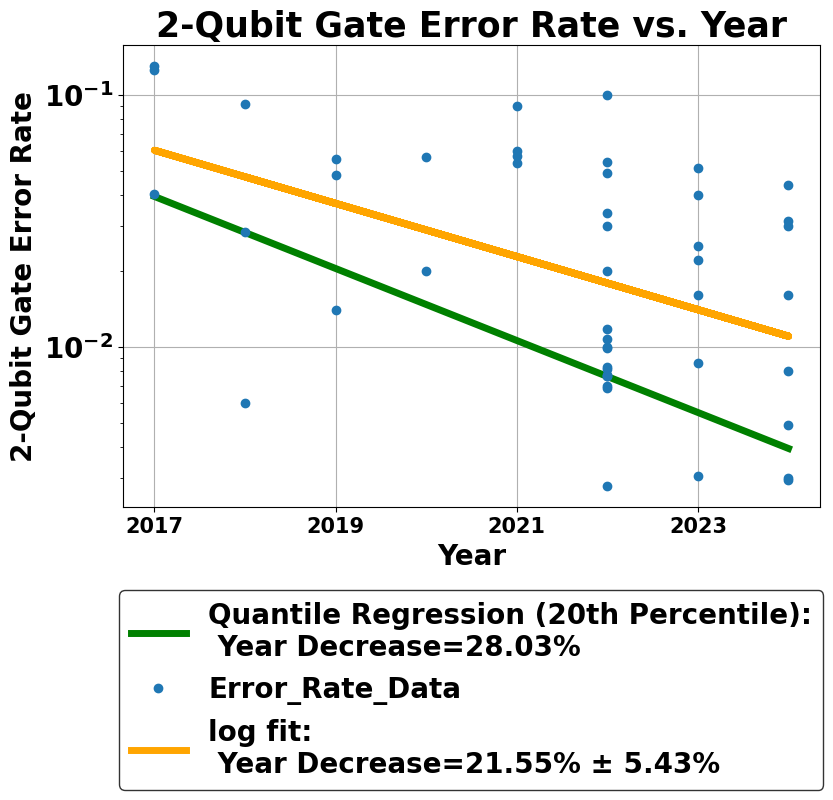

In [13]:
plt.figure(figsize=(9, 6))
# Filter the dataframe for superconducting technology
superconducting_df = cleaned_df[cleaned_df["Technology"] == "Superconducting"]
superconducting_df = superconducting_df[superconducting_df["Fidelity"].notnull()]

# Calculate the error rate
superconducting_df["Error_Rate"] = 1 - .01 * superconducting_df["Fidelity"]
superconducting_df["Log_Error_Rate"] = np.log10(superconducting_df["Error_Rate"])



# Calculate years since 2017
superconducting_df["Years_since_2017"] = superconducting_df["Year"] - 2017

# Fit a line to the log error rate
# coefficients = np.polyfit(superconducting_df["Years_since_2017"], superconducting_df["Log Error Rate"], 1)

coefficients, cov = np.polyfit(
    superconducting_df["Years_since_2017"], 
    superconducting_df["Log_Error_Rate"], 
    1, 
    cov=True
)
slope, intercept = coefficients
slope_err = np.sqrt(cov[0, 0])  # standard error of the slope
intercept_err = np.sqrt(cov[1, 1])  # standard error of the intercept
print(f"Slope: {slope:.4f} ± {slope_err:.4f}")
print(f"Intercept: {intercept:.4f} ± {intercept_err:.4f}")


# Convert slope to decimal fraction for the "multiply factor" each year
yearly_factor = 10**slope  # < 1 if error is decreasing; > 1 if error is increasing
percent_decrease = (1 - yearly_factor) * 100  # in %

# Propagate uncertainty
# df/dm = -ln(10) * 10^m  --> absolute value for the magnitude
deriv = np.log(10) * 10**slope
percent_decrease_err = deriv * slope_err * 100  # in %

print(
    f"Yearly percent decrease = {percent_decrease:.2f}% "
    f"± {percent_decrease_err:.2f}%"
)



# Print the fit parameters
slope, intercept = coefficients
print(f"Slope exponentiated: {10**slope}")
print(f"Intercept: {intercept}")


linear_fit = np.poly1d(coefficients)
years_since_2017 = np.linspace(min(superconducting_df["Years_since_2017"]), max(superconducting_df["Years_since_2017"]), 100)
fitted_log_error_rate = linear_fit(years_since_2017)

# plt.title("2-Qubit Error Rate of Superconducting Qubits vs. Year", fontsize=20, fontweight="bold")
# plt.legend(fontsize=20, loc='upper left', bbox_to_anchor=(1, 1))




# Perform quantile regression for the 20th percentile on the log-transformed error rates
quantile = 0.2
model = smf.quantreg('Log_Error_Rate ~ Years_since_2017', superconducting_df)
res = model.fit(q=quantile)

# Print the quantile regression results
print(res.summary())

# Generate fitted values for a smooth line
years_smooth = np.linspace(min(superconducting_df['Years_since_2017']), max(superconducting_df['Years_since_2017']), 100)
fitted_quantile_log_error_rate = res.predict(pd.DataFrame({'Years_since_2017': years_smooth}))
fitted_quantile_error_rate = 10**fitted_quantile_log_error_rate

# Plot the continuous fit line for the quantile regression
plt.plot(
    years_smooth + 2017,
    fitted_quantile_error_rate,
    "-",
    label=f"Quantile Regression (20th Percentile):\n Year Decrease={(1-10**res.params['Years_since_2017']):.2%}",
    color='green',  # Make the line color green
    linewidth=5  # Increase the line width
)

# Plot the year vs error rate
plt.plot(superconducting_df["Year"], 
         superconducting_df["Error_Rate"], 
         "o",
         label="Error_Rate_Data")
plt.yscale("log")

plt.plot(superconducting_df["Year"], 
         10**linear_fit(superconducting_df["Years_since_2017"]), 
         "-", 
         label=f"log fit: \n Year Decrease={(1-10**coefficients[0]):.2%} ± {percent_decrease_err:.2f}%",
         color='orange',  # Make the line color black
         linewidth=5)  # Increase the line width
plt.xlabel("Year", fontsize=20, fontweight="bold")
plt.ylabel("2-Qubit Gate Error Rate", fontsize=20, fontweight="bold")

font_properties = FontProperties()
font_properties.set_size(20)
font_properties.set_weight('bold')
#old legend format
# plt.legend(fontsize=20, 
#           loc='upper left', 
#           bbox_to_anchor=(1, 1),
#           frameon=True,  # Adds a frame around the legend
#           facecolor='white',  # White background
#           edgecolor='black', prop=font_properties)  # Black border
plt.legend(fontsize=20,
          loc='upper center',
          bbox_to_anchor=(0.5, -0.15), 
          frameon=True,  # Adds a frame around the legend
          facecolor='white',  # White background
          edgecolor='black', prop=font_properties)  # Black border
plt.yticks(fontsize=20, fontweight="bold")
plt.xticks(np.arange(2017, 2025, 2), fontsize=15, fontweight="bold")
plt.grid(True)

plt.title("2-Qubit Gate Error Rate vs. Year", fontsize=25, fontweight='bold')
plt.savefig("Figures/2-qubit-gate-error-vs-year.png", dpi=300, bbox_inches='tight')



# With Error Correction Overhead

Slope: 0.1036 ± 0.1228
Yearly percent change in ratio = 26.94% ± 35.91%


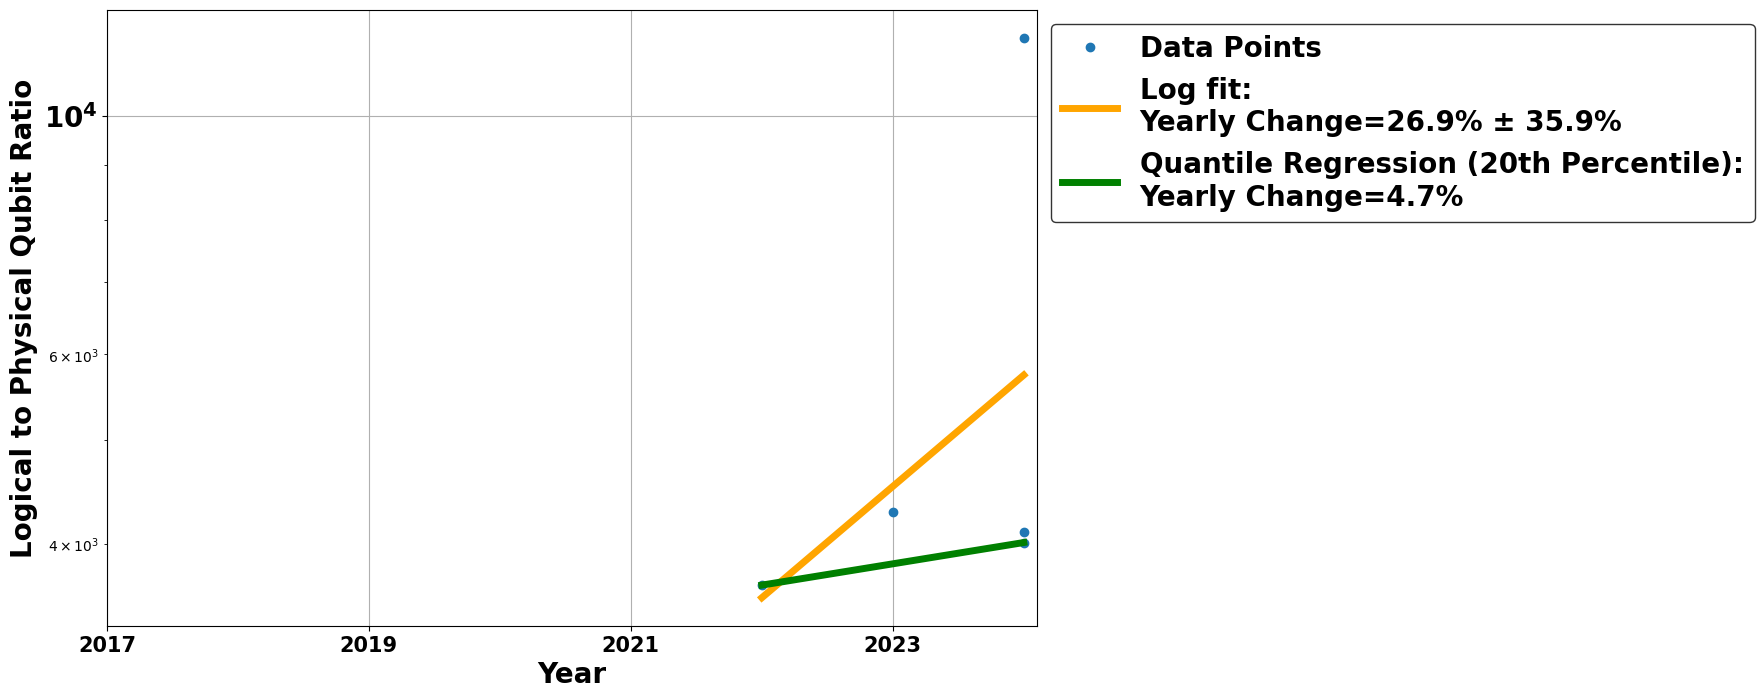

In [10]:
# Filter and analyze the logical to physical qubit ratio using the surface code formula
import math

def surface_code_formula(pP: float) -> float:
    pL = 1e-18  # Target logical error rate
    pth = 1e-2  # Threshold error rate
    numerator = 4 * math.log(math.sqrt(10 * pP / pL))
    denominator = math.log(pth / pP)
    fraction = numerator / denominator
    return (fraction + 1) ** 2  # Return logical to physical ratio directly

# Filter the dataframe for superconducting technology and error rates < 0.5%
superconducting_df = cleaned_df[cleaned_df["Technology"] == "Superconducting"]
superconducting_df = superconducting_df[superconducting_df["Fidelity"].notnull()]
superconducting_df["Error_Rate"] = 1 - .01 * superconducting_df["Fidelity"]
superconducting_df = superconducting_df[superconducting_df["Error_Rate"] < 0.005]  # Filter for < 0.5% error

# Calculate logical to physical ratio for each point
superconducting_df["Logical_to_Physical_Ratio"] = superconducting_df["Error_Rate"].apply(surface_code_formula)
superconducting_df["Log_Ratio"] = np.log10(superconducting_df["Logical_to_Physical_Ratio"])
superconducting_df["Years_since_2017"] = superconducting_df["Year"] - 2017

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(superconducting_df["Year"], 
         superconducting_df["Logical_to_Physical_Ratio"], 
         "o",
         label="Data Points")
plt.yscale("log")

# Fit a line to the log ratio
coefficients, cov = np.polyfit(
    superconducting_df["Years_since_2017"], 
    superconducting_df["Log_Ratio"], 
    1, 
    cov=True
)
slope, intercept = coefficients
slope_err = np.sqrt(cov[0, 0])
intercept_err = np.sqrt(cov[1, 1])

# Calculate and print statistics
yearly_factor = 10**slope
percent_change = (yearly_factor - 1) * 100
deriv = np.log(10) * 10**slope
percent_change_err = deriv * slope_err * 100

print(f"Slope: {slope:.4f} ± {slope_err:.4f}")
print(f"Yearly percent change in ratio = {percent_change:.2f}% ± {percent_change_err:.2f}%")

# Plot the fit line
years_since_2017 = np.linspace(min(superconducting_df["Years_since_2017"]), 
                              max(superconducting_df["Years_since_2017"]), 100)
linear_fit = np.poly1d(coefficients)
plt.plot(years_since_2017 + 2017, 
         10**linear_fit(years_since_2017), 
         "-", 
         label=f"Log fit:\nYearly Change={percent_change:.1f}% ± {percent_change_err:.1f}%",
         color='orange',
         linewidth=5)

# Perform quantile regression
quantile = 0.2
model = smf.quantreg('Log_Ratio ~ Years_since_2017', superconducting_df)
res = model.fit(q=quantile)

# Generate and plot quantile regression line
years_smooth = np.linspace(min(superconducting_df['Years_since_2017']), 
                          max(superconducting_df['Years_since_2017']), 100)
fitted_quantile_log_ratio = res.predict(pd.DataFrame({'Years_since_2017': years_smooth}))
fitted_quantile_ratio = 10**fitted_quantile_log_ratio

plt.plot(
    years_smooth + 2017,
    fitted_quantile_ratio,
    "-",
    label=f"Quantile Regression (20th Percentile):\nYearly Change={(10**res.params['Years_since_2017']-1):.1%}",
    color='green',
    linewidth=5
)

# Formatting
plt.xlabel("Year", fontsize=20, fontweight="bold")
plt.ylabel("Logical to Physical Qubit Ratio", fontsize=20, fontweight="bold")
plt.yticks(fontsize=20, fontweight="bold")
plt.xticks(np.arange(2017, 2025, 2), fontsize=15, fontweight="bold")
plt.grid(True)

font_properties = FontProperties()
font_properties.set_size(20)
font_properties.set_weight('bold')
plt.legend(fontsize=20,
          loc='upper left',
          bbox_to_anchor=(1, 1),
          frameon=True,
          facecolor='white',
          edgecolor='black',
          prop=font_properties)


Slope: -0.2273 ± 0.0680
Intercept: -1.3351 ± 0.3335
Yearly percent decrease = 40.75% ± 9.27%
Slope exponentiated: 0.5924675604652362
Intercept: -1.3351044460099757


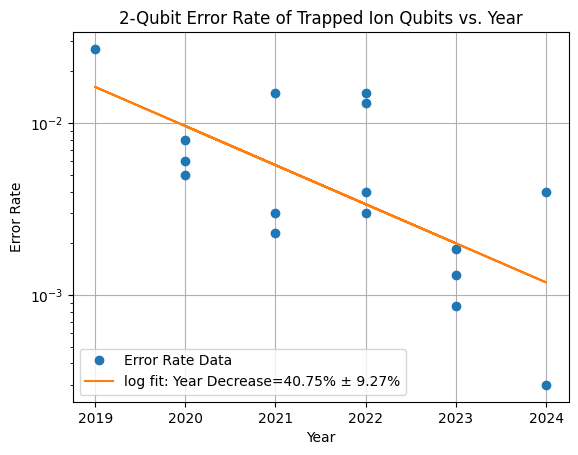

In [11]:

# Filter the dataframe for ion trap technology
ion_trap_df = cleaned_df[cleaned_df["Technology"] == "Trapped Ions"]
ion_trap_df = ion_trap_df[ion_trap_df["Fidelity"].notnull()]

# Calculate the error rate
ion_trap_df["Error Rate"] = 1 - .01 * ion_trap_df["Fidelity"]
ion_trap_df["Log Error Rate"] = np.log10(ion_trap_df["Error Rate"])

# Plot the year vs error rate
plt.plot(ion_trap_df["Year"], 
         ion_trap_df["Error Rate"], 
         "o",
         label="Error Rate Data")
plt.yscale("log")

# Calculate years since 2017
ion_trap_df["Years_since_2017"] = ion_trap_df["Year"] - 2017

# Fit a line to the log error rate
coefficients, cov = np.polyfit(
    ion_trap_df["Years_since_2017"], 
    ion_trap_df["Log Error Rate"], 
    1, 
    cov=True
)
slope, intercept = coefficients
slope_err = np.sqrt(cov[0, 0])  # standard error of the slope
intercept_err = np.sqrt(cov[1, 1])  # standard error of the intercept
print(f"Slope: {slope:.4f} ± {slope_err:.4f}")
print(f"Intercept: {intercept:.4f} ± {intercept_err:.4f}")

# Convert slope to decimal fraction for the "multiply factor" each year
yearly_factor = 10**slope  # < 1 if error is decreasing; > 1 if error is increasing
percent_decrease = (1 - yearly_factor) * 100  # in %

# Propagate uncertainty
deriv = np.log(10) * 10**slope
percent_decrease_err = deriv * slope_err * 100  # in %

print(
    f"Yearly percent decrease = {percent_decrease:.2f}% "
    f"± {percent_decrease_err:.2f}%"
)

linear_fit = np.poly1d(coefficients)
years_since_2017 = np.linspace(min(ion_trap_df["Years_since_2017"]), max(ion_trap_df["Years_since_2017"]), 100)
fitted_log_error_rate = linear_fit(years_since_2017)
plt.plot(ion_trap_df["Year"], 
         10**linear_fit(ion_trap_df["Years_since_2017"]), 
         "-", 
         label=f"log fit: Year Decrease={(1-10**coefficients[0]):.2%} ± {percent_decrease_err:.2f}%")
plt.xlabel("Year")
plt.ylabel("Error Rate")
plt.title("2-Qubit Error Rate of Trapped Ion Qubits vs. Year")
plt.grid(True)
plt.legend()

# Print the fit parameters
slope, intercept = coefficients
print(f"Slope exponentiated: {10**slope}")
print(f"Intercept: {intercept}")



In [12]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit

# # Provided data
# data = {
#     "Year": [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
#     "Superconducting_2Gate": [
#         0.9598,
#         0.994,
#         0.986,
#         0.98,
#         0.9466,
#         0.9972,
#         0.996921,
#         0.997039,
#     ],
#     "Superconducting_1Gate": [
#         0.999,
#         0.9981,
#         0.9988,
#         0.999,
#         0.9991,
#         0.999783,
#         0.999684,
#         0.9992,
#     ],
#     "TrappedIons_2Gate": [None, None, 0.973, 0.995, 0.9977, 0.997, 0.99914, 0.9997],
#     "TrappedIons_1Gate": [
#         None,
#         None,
#         0.996,
#         0.9997,
#         0.99996,
#         0.9998,
#         0.999979,
#         0.999992,
#     ],
# }
# # Convert to DataFrame
# df = pd.DataFrame(data)

# # Calculate 1 - Fidelity values
# df["Superconducting_2Gate"] = 1 - df["Superconducting_2Gate"]
# df["Superconducting_1Gate"] = 1 - df["Superconducting_1Gate"]
# df["TrappedIons_2Gate"] = 1 - df["TrappedIons_2Gate"]
# df["TrappedIons_1Gate"] = 1 - df["TrappedIons_1Gate"]

# # Define years for the x-axis
# years = df["Year"]
# # Define "years since 2017" for the x-axis
# df["Years_since_2017"] = df["Year"] - 2017
# years_since_2017 = df["Years_since_2017"]

# # Log transformation and removing NaN values
# df["log_Superconducting_2Gate"] = np.log10(df["Superconducting_2Gate"])
# df["log_Superconducting_1Gate"] = np.log10(df["Superconducting_1Gate"])
# df["log_TrappedIons_2Gate"] = np.log10(df["TrappedIons_2Gate"])
# df["log_TrappedIons_1Gate"] = np.log10(df["TrappedIons_1Gate"])

# # Removing rows with NaN for each category
# df_clean_super_2g = df.dropna(subset=["log_Superconducting_2Gate"])
# df_clean_super_1g = df.dropna(subset=["log_Superconducting_1Gate"])
# df_clean_ions_2g = df.dropna(subset=["log_TrappedIons_2Gate"])
# df_clean_ions_1g = df.dropna(subset=["log_TrappedIons_1Gate"])

# # Include logical to physical qubit ratio
# pl = 1e-18  # Define pl before using it
# scaling_factor_future = (
#     lambda fidelity: 2 * (4 * np.log(10 * pl) / np.log(100 * fidelity) - 1) ** 2 - 1
# )
# df["scaling_factor_future"] = np.log10(
#     scaling_factor_future(df["Superconducting_2Gate"])
# )
# df_clean_scaling = df.dropna(subset=["scaling_factor_future"])

# df["scaling_factor_iontrap"] = np.log10(scaling_factor_future(df["TrappedIons_2Gate"]))
# df_clean_scaling_iontrap = df.dropna(subset=["scaling_factor_iontrap"])


# # Linear fit for each category
# def linear_func(x, m, c):
#     return m * x + c


# # Fitting for Superconducting 2Gate
# popt_super_2g, _ = curve_fit(
#     linear_func,
#     df_clean_super_2g["Years_since_2017"],
#     df_clean_super_2g["log_Superconducting_2Gate"],
# )

# # Fitting for Superconducting 1Gate
# popt_super_1g, _ = curve_fit(
#     linear_func,
#     df_clean_super_1g["Years_since_2017"],
#     df_clean_super_1g["log_Superconducting_1Gate"],
# )

# # Fitting for TrappedIons 2Gate
# popt_ions_2g, _ = curve_fit(
#     linear_func,
#     df_clean_ions_2g["Years_since_2017"],
#     df_clean_ions_2g["log_TrappedIons_2Gate"],
# )

# # Fitting for TrappedIons 1Gate
# popt_ions_1g, _ = curve_fit(
#     linear_func,
#     df_clean_ions_1g["Years_since_2017"],
#     df_clean_ions_1g["log_TrappedIons_1Gate"],
# )

# # Fit logical to physical for superconducting
# popt_scaling, _ = curve_fit(
#     linear_func,
#     df_clean_scaling["Years_since_2017"],
#     df_clean_scaling["scaling_factor_future"],
# )

# pop_scaling_iontrap, _ = curve_fit(
#     linear_func,
#     df_clean_scaling_iontrap["Years_since_2017"],
#     df_clean_scaling_iontrap["scaling_factor_iontrap"],
# )

# # Plotting the results
# plt.figure(figsize=(10, 6))

# # Exponentiating the parameters to the power of 10
# exp_popt_super_2g = 10 ** np.array(popt_super_2g)
# exp_popt_super_1g = 10 ** np.array(popt_super_1g)
# exp_popt_ions_2g = 10 ** np.array(popt_ions_2g)
# exp_popt_ions_1g = 10 ** np.array(popt_ions_1g)


# # Plot for Superconducting 2Gate
# plt.scatter(
#     df_clean_super_2g["Year"],
#     df_clean_super_2g["log_Superconducting_2Gate"],
#     label="Superconducting 2Gate (data)",
#     color="blue",
# )
# plt.plot(
#     df_clean_super_2g["Year"],
#     linear_func(df_clean_super_2g["Years_since_2017"], *popt_super_2g),
#     label=f"Superconducting 2Gate (fit): year percentage decrease={(1- exp_popt_super_2g[0]):.1%}",
#     color="blue",
# )
# # percentage_decrease={(1- exp_popt_super_2g[0]):.2%}

# # Plot for Superconducting 1Gate
# # plt.scatter(
# #     df_clean_super_1g["Year"],
# #     df_clean_super_1g["log_Superconducting_1Gate"],
# #     label="Superconducting 1Gate (data)",
# #     color="green",
# # )
# # plt.plot(
# #     df_clean_super_1g["Year"],
# #     linear_func(df_clean_super_1g["Years_since_2017"], *popt_super_1g),
# #     label=f"Superconducting 1Gate (fit): m={exp_popt_super_1g[0]:.2}, c={exp_popt_super_1g[1]:.2}",
# #     color="green",
# # )

# # Plot for TrappedIons 2Gate
# plt.scatter(
#     df_clean_ions_2g["Year"],
#     df_clean_ions_2g["log_TrappedIons_2Gate"],
#     label="TrappedIons 2Gate (data)",
#     color="red",
# )
# plt.plot(
#     df_clean_ions_2g["Year"],
#     linear_func(df_clean_ions_2g["Years_since_2017"], *popt_ions_2g),
#     label=f"TrappedIons 2Gate (fit): year percentage decrease={(1-exp_popt_ions_2g[0]):.1%}",
#     color="red",
# )

# # label=f"TrappedIons 2Gate (fit): m={exp_popt_ions_2g[0]:.2}, c={exp_popt_ions_2g[1]:.2}"

# # Plot for TrappedIons 1Gate
# # plt.scatter(
# #     df_clean_ions_1g["Year"],
# #     df_clean_ions_1g["log_TrappedIons_1Gate"],
# #     label="TrappedIons 1Gate (data)",
# #     color="orange",
# # )
# # plt.plot(
# #     df_clean_ions_1g["Year"],
# #     linear_func(df_clean_ions_1g["Years_since_2017"], *popt_ions_1g),
# #     label=f"TrappedIons 1Gate (fit): m={exp_popt_ions_1g[0]:.2}, c={exp_popt_ions_1g[1]:.2}",
# #     color="orange",
# # )

# # Plot logical to physical ratio fit
# # plt.scatter(df_clean_scaling["Year"], df_clean_scaling["scaling_factor_future"], label="Logical/Physical Ratio (data)", color="purple")
# # plt.plot(df_clean_scaling["Year"], linear_func(df_clean_scaling["Years_since_2017"], *popt_scaling), label=f"Logical/Physical Ratio (fit): m={popt_scaling[0]:.2e}, c={popt_scaling[1]:.2e}", color="purple")

# # Labels and title
# plt.xlabel("Year")
# plt.ylabel("log(Error rate)")
# plt.title("2-Qubit Gate Error Rate Over Time: Superconducting vs. Trapped Ions")
# plt.legend(fontsize=12)
# plt.grid(True)
# plt.show()


# # I want to print out the the fit intercept exponentiated for each group
# print(
#     f"Superconducting 2 gate fit intercep (initial error rate)t: {10**popt_super_2g[1]}"
# )
# print(f"TrappedIons 2 gate fit intercept (initial error rate): {10**popt_ions_2g[1]}")

# Mapping Out Physical Qubits Over Time

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_13611/90900053.py:57: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(


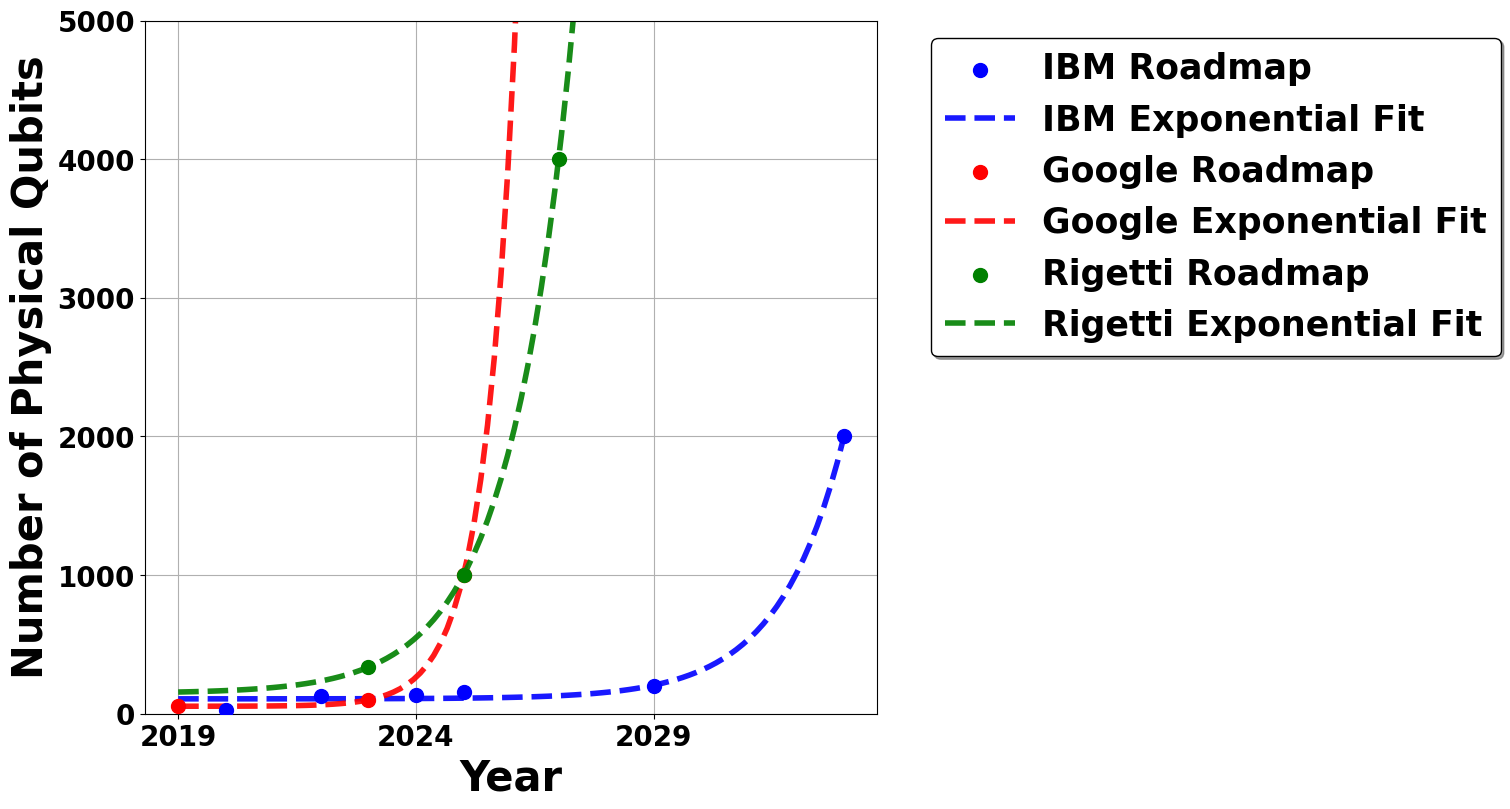

In [13]:
# graph roadmaps



import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Roadmap data
IBM_roadmap = {
    2020: 27,
    2022: 127,
    2024: 133,
    2025: 156,
    2029: 200,
    2033: 2000,
}

Google_roadmap = {
    2019: 54,
    2023: 100,
    2025: 1000,
}

Rigetti_roadmap = {
    2023: 336,
    2025: 1000,
    2027: 4000,
}

best_system_roadmap = {
    2016:22,
    2018:48, 
    2018:72, 
    2021:126,
    2022:433,
    2023:1120,
}


# Define improved exponential function for fitting
def exp_func(x, a, b, c):
    """Exponential function of the form a * exp(b * (x - x0)) + c"""
    return a * np.exp(b * (x - 2019)) + c


# Function to fit and plot data
def fit_and_plot_roadmap(data_dict, label, color):
    years = np.array(list(data_dict.keys()))
    qubits = np.array(list(data_dict.values()))

    # Initial parameter guesses
    p0 = [min(qubits), 0.5, 0]

    # Fit with better bounds
    try:
        popt, _ = curve_fit(
            exp_func, years, qubits, p0=p0, bounds=([0, -2, -1000], [10000, 2, 1000])
        )
    except RuntimeError:
        print(f"Fitting failed for {label}")
        return None

    # Generate smooth curve for plotting
    # years_smooth = np.linspace(2019, max(years), 100)
    years_smooth = np.linspace(2019, 2033, 100)
    fit_smooth = exp_func(years_smooth, *popt)

    # Plot original data points
    plt.scatter(years, qubits, color=color, label=f"{label} Roadmap", zorder=5, s=100)

    # Plot fitted curve
    plt.plot(
        years_smooth,
        fit_smooth,
        "--",
        color=color,
        label=f"{label} Exponential Fit",
        alpha=0.9,
        linewidth=4,
    )

    return popt

# Create plot
# plt.figure(figsize=(12, 8))
#make figsize long horizontally
plt.figure(figsize=(15, 8))
# Fit and plot each company's data
fit_and_plot_roadmap(IBM_roadmap, "IBM", "blue")
fit_and_plot_roadmap(Google_roadmap, "Google", "red")
fit_and_plot_roadmap(Rigetti_roadmap, "Rigetti", "green")
# fit_and_plot_roadmap(best_system_roadmap, "Best System", "purple")

# Customize plot
plt.xlabel("Year", fontsize=30, fontweight='bold')
plt.ylabel("Number of Physical Qubits", fontsize=30, fontweight='bold')
# plt.title("Quantum Computing Roadmaps: Projected Number of Physical Qubits", fontsize=19, weight="bold")
plt.grid(True)


font_properties = FontProperties()
font_properties.set_size(25)
font_properties.set_weight('bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=25, frameon=True, shadow=True, facecolor='white', edgecolor='black', fancybox=True, prop=font_properties)
plt.ylim(0, 5000)

#make the legend larger and towards the right
# 

# Use logarithmic scale for y-axis since the growth is exponential


# Add minor gridlines
plt.grid(True, which="minor", alpha=0.9)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.xticks(fontsize=20, fontweight='bold')
plt.xticks(np.arange(2019, 2032, 5), fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
plt.show()

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_13611/954959904.py:44: RuntimeWarning: overflow encountered in scalar power
  problem_size = 2**logical_qubits
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_13611/954959904.py:54: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(


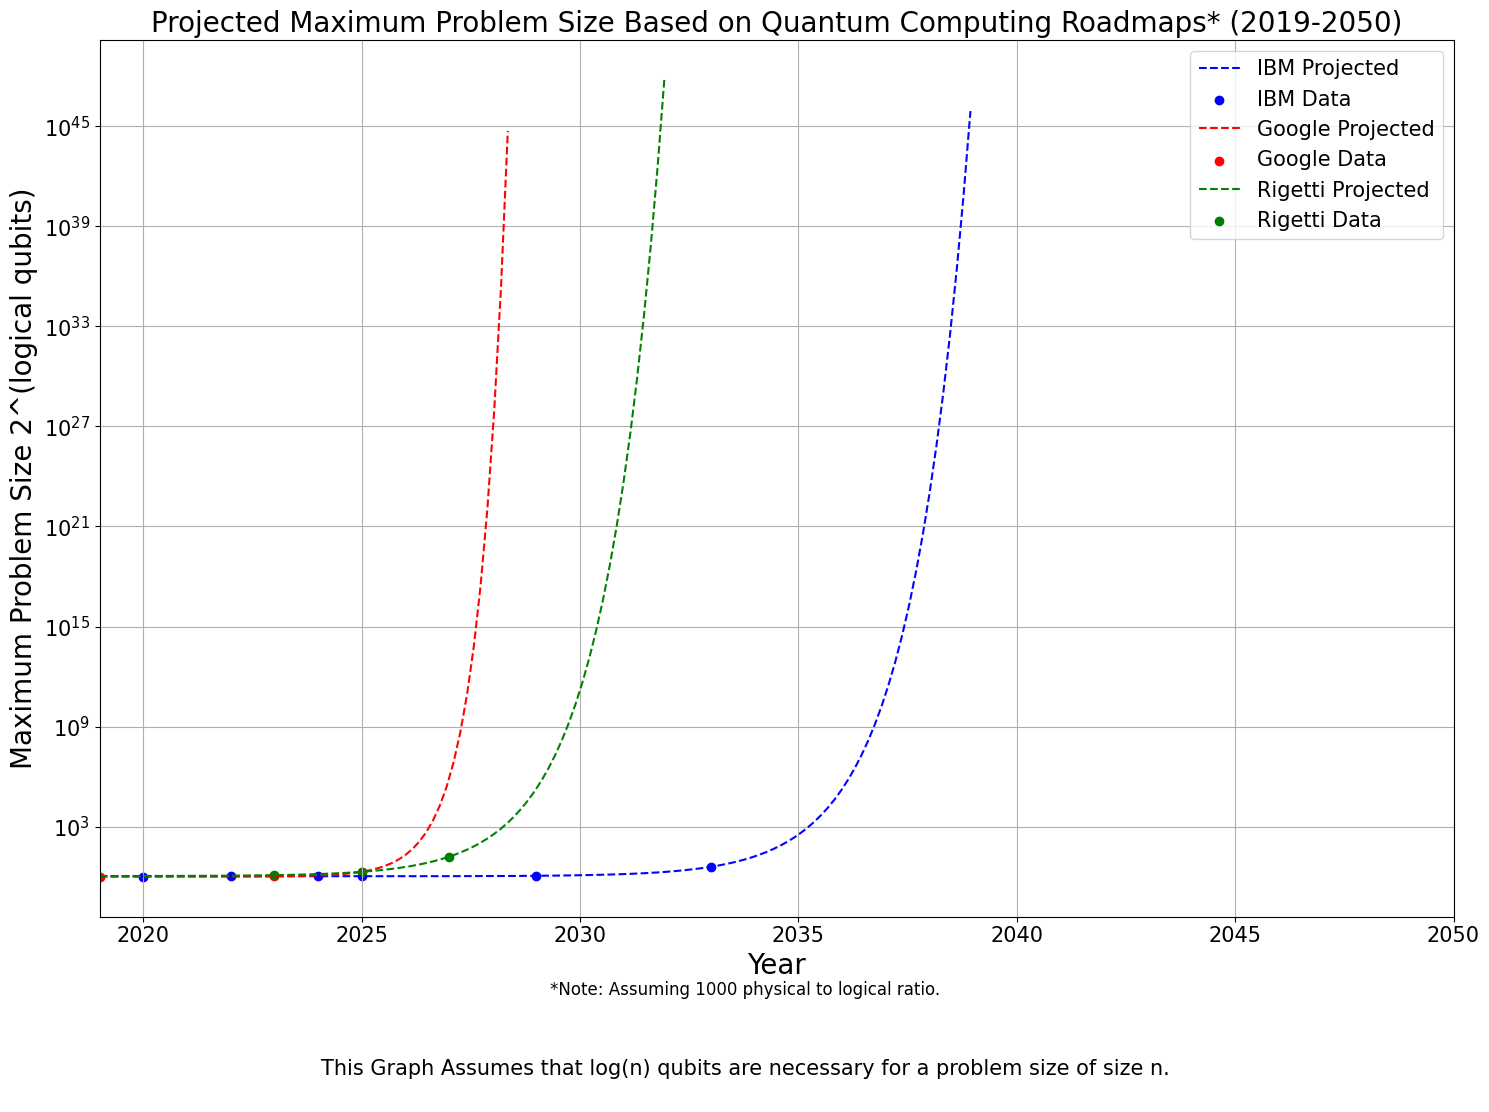

In [14]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Original roadmap data
IBM_roadmap = {
    2020: 27,
    2022: 127,
    2024: 133,
    2025: 156,
    2029: 200,
    2033: 2000,
}

Google_roadmap = {
    2019: 54,
    2023: 100,
    2025: 1000,
}

Rigetti_roadmap = {
    2023: 336,
    2025: 1000,
    2027: 4000,
}

# Constants
PHYSICAL_TO_LOGICAL_RATIO = 1000  # 10^3 physical qubits per logical qubit
MAX_PROBLEM_SIZE = 1e50  # Maximum problem size to consider


def exp_func(x, a, b, c):
    """Exponential function for fitting"""
    return a * np.exp(b * (x - 2019)) + c


def calculate_problem_size(physical_qubits):
    """Calculate problem size from physical qubits"""
    logical_qubits = physical_qubits / PHYSICAL_TO_LOGICAL_RATIO
    # Only calculate for positive logical qubits
    if logical_qubits <= 0:
        return 0
    # Cap the maximum problem size
    problem_size = 2**logical_qubits
    return min(problem_size, MAX_PROBLEM_SIZE)


def fit_and_extrapolate(data_dict, company_name, color):
    # Fit original data
    years = np.array(list(data_dict.keys()))
    qubits = np.array(list(data_dict.values()))

    try:
        popt, _ = curve_fit(
            exp_func,
            years,
            qubits,
            p0=[min(qubits), 0.5, 0],
            bounds=([0, -2, -1000], [10000, 2, 1000]),
        )
    except RuntimeError:
        print(f"Fitting failed for {company_name}")
        return None

    # Generate extrapolated years and corresponding qubit numbers
    years_extended = np.linspace(
        2019, 2050, 200
    )  # Increased number of points for smoother curve
    qubits_extended = exp_func(years_extended, *popt)

    # Calculate problem sizes
    problem_sizes = np.array([calculate_problem_size(q) for q in qubits_extended])

    # Only plot where problem size is > 0 and < MAX_PROBLEM_SIZE
    valid_mask = (problem_sizes > 0) & (problem_sizes < MAX_PROBLEM_SIZE)

    if np.any(valid_mask):
        plt.plot(
            years_extended[valid_mask],
            problem_sizes[valid_mask],
            "--",
            color=color,
            label=f"{company_name} Projected",
            alpha=0.99,
        )

        # Plot original data points converted to problem size
        original_problem_sizes = [calculate_problem_size(q) for q in qubits]
        valid_original = np.array(original_problem_sizes) < MAX_PROBLEM_SIZE
        plt.scatter(
            years[valid_original],
            np.array(original_problem_sizes)[valid_original],
            color=color,
            label=f"{company_name} Data",
        )

        # Add the year when MAX_PROBLEM_SIZE is reached
        # if np.any(problem_sizes >= MAX_PROBLEM_SIZE):
        #     year_max = years_extended[problem_sizes >= MAX_PROBLEM_SIZE][0]
        #     plt.annotate(f'{company_name}\nreaches max\nat {year_max:.1f}',
        #                 xy=(year_max, MAX_PROBLEM_SIZE),
        #                 xytext=(5, 5), textcoords='offset points',
        #                 fontsize=8, color=color)


# Create plot
plt.figure(figsize=(15, 10))  # Increased figure size for better visibility

# Fit and plot each company's data
fit_and_extrapolate(IBM_roadmap, "IBM", "blue")
fit_and_extrapolate(Google_roadmap, "Google", "red")
fit_and_extrapolate(Rigetti_roadmap, "Rigetti", "green")

# Customize plot
plt.xlabel("Year", fontsize=20)  # Enlarged x-axis label
plt.ylabel("Maximum Problem Size 2^(logical qubits)", fontsize=20)  # Enlarged y-axis label
plt.yticks(fontsize=15)  # Enlarged tick labels
plt.xticks(fontsize=15)  # Enlarged tick labels
plt.title(
    "Projected Maximum Problem Size Based on Quantum Computing Roadmaps* (2019-2050)",
    fontsize=20,
)
plt.grid(True)
plt.legend(fontsize=15)
plt.figtext(0.5, 0.0, "*Note: Assuming 1000 physical to logical ratio.", ha="center", fontsize=12)

# Use logarithmic scale for y-axis
plt.yscale("log")

# Add minor gridlines
plt.grid(True, which="minor", alpha=0.2)

# Set x-axis limits explicitly
plt.xlim(2019, 2050)

# Add blurb
blurb = (
    "This Graph Assumes that log(n) qubits are necessary for a problem size of size n.\n" 

)
plt.figtext(0.5, -0.1, blurb, wrap=True, horizontalalignment='center', fontsize=15)

# Adjust layout
plt.tight_layout()

plt.show()


In [15]:
# now lets look at sensitiv